# Finding base magnitudes for $t_{\mbox{eff}}$

## Notebook setup

### Logging

Do it first so I can use logging to track how long imports take.

In [1]:
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
logger.info("Starting")

2021-04-27 14:43:50,598 Starting


### Imports

In [2]:
import os
import os.path
import copy

In [3]:
logger.debug("Loading common modules")
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

2021-04-27 14:43:50,632 Loading common modules


In [4]:
logger.debug("Loading general astronomy modules")
import healpy
import palpy
import astropy
import astropy.coordinates
from astropy.coordinates import EarthLocation
from astropy.time import Time
import astropy.units as u

2021-04-27 14:43:51,825 Loading general astronomy modules


In [5]:
logger.debug("Loading Rubin Observatory modules")
import lsst.sims.utils
from lsst.sims.utils import m5_flat_sed
from lsst.sims.seeingModel import SeeingData, SeeingModel
from lsst.sims.cloudModel import CloudData
from lsst.sims.skybrightness_pre import SkyModelPre

2021-04-27 14:43:53,098 Loading Rubin Observatory modules
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2021_09-dev/stack/miniconda3-py38_4.9.2-0.4.1/Linux64/sims_utils/2.13.0.sims-44-g40e226b+78010079df/python/lsst/sims/utils/Site.py:132: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self._name is 'LSST':


In [6]:
lsst.sims.seeingModel.__version__

'master-ga4bf72ea44+06e1856cbb'

In [7]:
lsst.sims.cloudModel.__version__

'master-ge3724df529+ea94b09898'

### Plot setup

In [8]:
mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')
np.random.seed(6563)

### Constants

In [9]:
sky_data_path = os.path.join(os.environ['SIMS_SKYBRIGHTNESS_DATA'], 'healpix')
sky_model = lsst.sims.skybrightness_pre.SkyModelPre(data_path=sky_data_path)
site = EarthLocation.of_site('Cerro Pachon')
bands = pd.Series(('u', 'g', 'r', 'i', 'z', 'y')).rename('band')
seeing500 = 0.69 ;# See ./Model_Pachon_r0.ipynb cell 42, also https://docs.google.com/presentation/d/1GEazuX-iKM1IttHlo5S3s7pyVkWfk0EVEDvhMlbaDjA
mjd_sample_rate = 0.01 ;# Every 0.01 days = every 14.4 minutes

## Seeing

In [10]:
seeing_model = SeeingModel()
seeing = pd.Series(seeing_model(seeing500, 1.0)['fwhmEff'], index=bands)
seeing

band
u    1.006968
g    0.946801
r    0.893110
i    0.857011
z    0.831870
y    0.812705
dtype: float64

## Sky

In [11]:
%%time
mjd_range = (astropy.time.Time('2022-10-01T16:00:00Z').mjd, astropy.time.Time('2032-10-01T16:00:00Z').mjd)
all_mjds = np.arange(*mjd_range, mjd_sample_rate)
all_times = astropy.time.Time(all_mjds, scale='utc', format='mjd', location=site)
sun_coords = astropy.coordinates.get_sun(all_times).transform_to(astropy.coordinates.AltAz(obstime=all_times, location=site))
moon_coords = astropy.coordinates.get_moon(all_times).transform_to(astropy.coordinates.AltAz(obstime=all_times, location=site))
dark_idxs = np.logical_and(sun_coords.alt.deg < -18, moon_coords.alt.deg < -18)
mjds = all_mjds[dark_idxs]
times = all_times[dark_idxs]

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2021_09-dev/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1-ext/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2021_09-dev/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1-ext/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 246666 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2021-04-27 14:45:29,992 Tried to get polar motions for times after IERS data is valid. Defaulting to polar motion from the 50-yr mean for those. This may affect precision at the arcsec level
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2021_09-dev/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1-ext/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function 

CPU times: user 11min 42s, sys: 2.03 s, total: 11min 44s
Wall time: 11min 45s


Find the healpixels for the standard pointing for the sampled times:

In [12]:
def find_zenith_hpixs(mjd, site, nside, north=True):
    lst = Time(mjd, format='mjd', location=site).sidereal_time('apparent').to_value(u.degree)
    ra = lst
    decl = site.lat.deg
    hpix = healpy.ang2pix(nside, ra, decl, lonlat=True)
    return hpix

Actually calculate the sky brightnesses:

/data/des91.b/data/neilsen/LSST/devel/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:373: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')


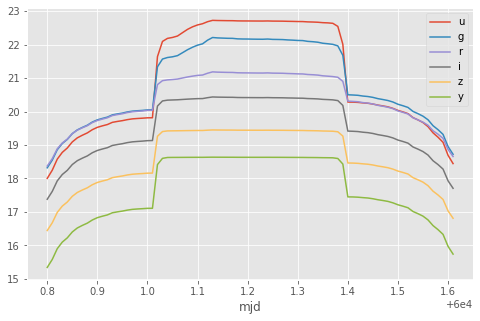

In [13]:
def compute_zenith_mags(mjds, sky_model, **kwargs):
    zenith_hpixs = pd.DataFrame({'mjd': mjds,
                                 'hpix': find_zenith_hpixs(mjds, **kwargs)})
    mags = zenith_hpixs.apply(
        lambda x: pd.Series({k: m[0] for k, m in sky_model.returnMags(x.mjd, indx=np.array([x.hpix], dtype=int), badval=np.nan, zenith_mask=False).items()}),
        axis=1)
    mags['mjd'] = mjds
    return mags
    
if __debug__:
    df = compute_transiting_mags(np.arange(60000.7, 60001.7, 0.01), sky_model, site=site, nside=sky_model.nside)
    ax = None
    for band in bands:
        ax = df.plot('mjd', band, ax=ax)

In [14]:
%%time
dark_sky_mags = compute_zenith_mags(mjds, sky_model=sky_model, site=site, nside=sky_model.nside)

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2021_09-dev/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1-ext/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 35814 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2021_09-dev/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1-ext/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 35814 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


CPU times: user 2min 51s, sys: 3min 1s, total: 5min 53s
Wall time: 5min 56s


In [15]:
median_dark_sky = dark_sky_mags.median()
median_dark_sky

u         22.680631
g         22.105630
r         21.113016
i         20.391814
z         19.431007
y         18.627197
mjd    61710.151667
dtype: float64

In [16]:
m0 = pd.DataFrame({
    'band': bands,
    'min_wavelength': (350.0, 400.0, 552.0, 691.0, 818.0, 949.0),
    'max_wavelength': (400.0, 552.0, 691.2, 818.0, 922.0, 1060.0)}
).set_index('band', drop=False)

m0.apply(
        lambda r: m5_flat_sed(r['band'], median_dark_sky[r['band']], seeing[r['band']], expTime=15, airmass=1, nexp=2), axis=1).round(2)

band
u    23.60
g    24.65
r    24.23
i    23.80
z    23.19
y    22.38
dtype: float64